In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers==4.0 contractions torch==1.3.1
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn, cuda
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.gridspec as gridspec
import seaborn
import transformers
import torch
import nltk
import re
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda, nn
import torch
device = 'cuda' if cuda.is_available() else 'cpu'

     |████████████████████████████████| 1.4MB 13.9MB/s 
     |████████████████████████████████| 734.6MB 21kB/s 
     |████████████████████████████████| 2.9MB 53.2MB/s 
     |████████████████████████████████| 901kB 47.4MB/s 
     |████████████████████████████████| 327kB 68.5MB/s 
     |████████████████████████████████| 286kB 60.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85396 sha256=26eaf2c96e1ae39105a8edadaea2f7958600303149e672710e15e065f589d2bd
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.3.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv("/content/drive/MyDrive/punctuation data/tr_ds_ds.csv")
df.drop(columns=["text", "Unnamed: 0"], axis=1, inplace=True)
df.head()

,clean_txt
0,zemfira musakızı aliyeva azerbaycanlı dilcibil...
1,hayatı. \n
2,"aliyeva zemfira musakızı, 1950 yılının 24 hazi..."
3,"ailelidir, 3 evladı vardır. \n"
4,"belarus, türkiyenin i̇stanbul şehrinde düzenle..."


In [4]:
def plotCurves(stats, path, f1=False):
    fig = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = fig.add_subplot(spec2[0, 0])
    ax2 = fig.add_subplot(spec2[0, 1])
    ax3 = fig.add_subplot(spec2[1, 0])
    for i in ['train_loss', 'valid_loss']: 
      ax1.plot(stats[i], label=i)
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    for j in ['train_acc', 'valid_acc']: 
      ax2.plot(100 * stats[j], label=j)
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    if f1:
        for c in ['train_f1', 'valid_f1']: 
          ax3.plot(stats[c], label=c)
        ax3.legend()
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('F1 Score')
    fig.savefig(path+'/Metrics.png')

In [5]:
def removeDigits(string):
  string = string.lower().replace("\n", "")
  return ''.join(i for i in string if not i.isdigit())

def getLength(string):
  return len(string.split(" "))

In [6]:
# Remove empty string from list
def removeEmpty(li):
  while("" in li) :
      li.remove("")
  while(" " in li) :
      li.remove(" ")
  return li

# Remove other punctuations
def removePunct(sent):
  updt = sent.replace(':','').replace(';','').replace("'",'').replace('"','').replace('(','').replace(')','').replace('_','').replace('/','').replace('__','')
  return updt

In [7]:
def labels(samples):
  li = []
  for each in samples:
    each = each.strip()
    if "," in each:
      li.append(1)
    elif "?" in each:
      li.append(2)
    elif "." in each:
      li.append(3)
    elif "!" in each:
      li.append(4)  
    else: li.append(0)
  return li

In [8]:
# Remove Digits
df["clean_txt"] = df["clean_txt"].apply(lambda x: removeDigits(x))
# Remove punctuations
df["clean_txt"] = df["clean_txt"].apply(lambda x: removePunct(x))
# Splitting into tokens
df["tokens"] = df['clean_txt'].apply(lambda x: x.split(" "))
df.head()

,clean_txt,tokens
0,zemfira musakızı aliyeva azerbaycanlı dilcibil...,"[zemfira, musakızı, aliyeva, azerbaycanlı, dil..."
1,hayatı.,"[hayatı., ]"
2,"aliyeva zemfira musakızı, yılının haziranınd...","[aliyeva, zemfira, musakızı,, , yılının, , haz..."
3,"ailelidir, evladı vardır.","[ailelidir,, , evladı, vardır., , ]"
4,"belarus, türkiyenin i̇stanbul şehrinde düzenle...","[belarus,, türkiyenin, i̇stanbul, şehrinde, dü..."


In [9]:
# Remove EMPTY
df['new_tokens'] = df['tokens'].apply(lambda x: removeEmpty(x))
# Getting length
df['length'] = df['tokens'].apply(lambda x: len(x))
# Create Labels
df['labels'] = df['tokens'].apply(lambda x: labels(x))

In [10]:
df.drop(['clean_txt', 'tokens'], axis=1, inplace=True) 
df.head()

,new_tokens,length,labels
0,"[zemfira, musakızı, aliyeva, azerbaycanlı, dil...",9,"[0, 0, 0, 0, 1, 1, 0, 0, 3]"
1,[hayatı.],1,[3]
2,"[aliyeva, zemfira, musakızı,, yılının, haziran...",136,"[0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ..."
3,"[ailelidir,, evladı, vardır.]",3,"[1, 0, 3]"
4,"[belarus,, türkiyenin, i̇stanbul, şehrinde, dü...",9,"[1, 0, 0, 0, 0, 0, 0, 0, 3]"


In [11]:
# Using data with length more than 50
df=df[df['length'] > 52]
len(df)

20838

## Model Class

In [12]:
# # Create a yaml file by name of model.yanl and put this in that 
# debug:
#   summary_writer: true
#   break_train_loop: false

# experiment:
#   name: bert-base-multilingual-uncased-unfreezed

# data:
#   data_path: /userhome/student/bial/neural-punctuator/data/bert-base-multilingual-uncased/
#   output_labels: [empty, period, question, comma]

# preprocessor:
#   preproc_arg: TODO

# model:
#   name: szeged
#   load_model_repo: bert-base-multilingual-uncased
#   bert_output_dim: 768
#   linear_hidden_dim: 2048
#   num_classes: 5
#   seq_len: 512
#   dropout: 0.2

#   save_model_path: /userhome/student/bial/neural-punctuator/models/

# trainer:
#   use_gpu: cuda:0
#   batch_size: 4
#   num_epochs: 12
#   shuffle: true
#   optimizer: adamw
#   loss: NLLLoss
#   base_learning_rate: 0.00003 #3e-5
#   classifier_learning_rate: 0.0001 #1e-4
#   metrics: [precision, recall, f-score, auc]
#   warmup_steps: 300
#   clip_seq: 32
#   grad_clip: 1.5
#   train_bert: true
#   #load_model:
#   seq_shift: 32   # Shift each training sample +-seq_shift to get more different samples
#   show_confusion_matrix: false

In [13]:
!pip install dotmap
import logging
import sys
import numpy as np
from abc import abstractmethod
import torch
import torch.nn as nn


handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter('%(asctime)s %(levelname)-9s %(message)s'))

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(handler)


class BaseModel(nn.Module):
    """
    Base class for all torch models
    """
    def __init__(self, config):
        super().__init__()
        self._config = config

    @abstractmethod
    def forward(self, *inputs):
        """
        Forward pass logic
        :return: Model output
        """
        raise NotImplementedError

    def __str__(self):
        """
        Model prints with number of trainable parameters
        """
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return super().__str__() + '\nTrainable parameters: {}'.format(params)

    def save_model(self, optimizer, epoch):
        log.info("Saving model...")
        torch.save(self.state_dict(), f'saved/models/{self._config.model.name}_{str(epoch)}.pth')
        torch.save(optimizer.state_dict(), f'saved/models/{self._config.model.name}_{str(epoch)}_optimizer_state.pth')

    def load_model(self, optimizer, epoch, model_name):
        log.info("Loading model...")
        self.load_state_dict(torch.load(f'saved/models/{model_name}_{str(epoch)}.pth'))
        optimizer.load_state_dict(torch.load(f'saved/models/{model_name}_{str(epoch)}_optimizer_state.pth'))

from typing import Any

import torch
from torch import nn
import torch.nn.functional as F


from transformers import AutoTokenizer, AutoModel


class BertPunctuator(BaseModel):
    def __init__(self, config):
        super().__init__(config)
        # self.base = torch.hub.load(self._config.model.bert_github_repo, 'model', self._config.model.bert_variant_to_load)
        self.base = AutoModel.from_pretrained(self._config.model.load_model_repo)

        if not self._config.trainer.train_bert:
            for param in self.base.parameters():
                param.requires_grad = False

        self.classifier = Classifier(self._config)

    def forward(self, x, y):
        if self._config.trainer.train_bert:
            embedding, _ = self.base(input_ids=x, attention_mask=y, return_dict=False)
        else:
            with torch.no_grad():
                embedding, _ = self.base(input_ids=x, attention_mask=y, return_dict=False)

        output = self.classifier(embedding)
        output = F.log_softmax(output, dim=-1)
        return output

    def train(self, mode=True):
        if mode:
            if self._config.trainer.train_bert:
                self.base.train()
            else:
                self.base.eval()
            self.classifier.train()
        else:
            self.base.eval()
            self.classifier.eval()
        return self

    def eval(self):
        self.train(False)
        return self


class Classifier(BaseModel):
    def __init__(self, config):
        super().__init__(None)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(config.model.bert_output_dim, config.model.linear_hidden_dim)
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(config.model.linear_hidden_dim, config.model.num_classes)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.activation(self.linear1(x))
        x = self.dropout2(x)
        x = self.linear2(x)
        return x


import yaml
from dotmap import DotMap
def get_config_from_yaml(yaml_file):
    with open(yaml_file, 'r') as config_file:
        config_yaml = yaml.load(config_file)
    # Using DotMap we will be able to reference nested parameters via attribute such as x.y instead of x['y']
    config = DotMap(config_yaml)
    return config

  

In [14]:
config = get_config_from_yaml('/content/drive/MyDrive/punctuation data/model.yaml')
model = BertPunctuator(config)
model.to(device)

BertPunctuator(
  (base): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

## Our Dataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, label, device):
        # super(CustomDataset, self).__init__(dataframe, label)
        self.dataframe = dataframe
        self.ids = self.dataframe['input_ids'].values.tolist()
        self.mask = self.dataframe['attention_mask'].values.tolist()
        self.targets = label.values.tolist()
       
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        ids = self.ids[index]
        mask = self.mask[index]
        t_value = self.targets[index]       #index by iteration
        return {
            'ids': torch.tensor(ids, dtype=torch.long).to(device, dtype = torch.long),
            'mask': torch.tensor(mask, dtype=torch.long).to(device, dtype = torch.long),
            'targets': torch.tensor(t_value, dtype=torch.long).to(device)
        }
        

## initializing tokenizers

In [16]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [17]:
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(list(examples['new_tokens']), truncation=True, is_split_into_words=True, max_length=512, pad_to_max_length=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(0)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else 0)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
df.head()

,new_tokens,length,labels
2,"[aliyeva, zemfira, musakızı,, yılının, haziran...",136,"[0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ..."
433,"[filinta, bi, küçük, eylül, meselesi, adlı, ya...",61,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
435,"[i̇stanbula, geldiğinde, mota, ümit, çırakla,,...",70,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
737,"[i̇slam, dinine, geçişle, beraber, kürt, halkı...",53,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
869,"[buzul, cilaları, buzul, cilaları,, buzulun, y...",54,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ..."


In [19]:
inputs = tokenize_and_align_labels(df)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [21]:
df_train = pd.DataFrame.from_dict(inputs, orient='index')
df_train = df_train.T
df_train.head()

,input_ids,attention_mask,labels
0,"[101, 4862, 17240, 2050, 27838, 2213, 8873, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
1,"[101, 10882, 4115, 2696, 12170, 13970, 10841, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[101, 9960, 2050, 21500, 4305, 11528, 3207, 95...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."
3,"[101, 7025, 11586, 3170, 16216, 22987, 2571, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[101, 20934, 9759, 2140, 25022, 13837, 2906, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."


In [22]:
L = ['input_ids','attention_mask','labels']
for z in L:
  for i in df_train[z]:
    if len(i) != 512:
      print('error')

## Data splitting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns = 'labels', axis=1), df_train['labels'], test_size=0.40, random_state=42)

## now creating custom classes.

In [24]:
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 6
training_set = CustomDataset(X_train, y_train, device)
testing_set = CustomDataset(X_test, y_test, device)
training_loader = DataLoader(training_set, batch_size = TRAIN_BATCH_SIZE, num_workers=0, shuffle = True)
testing_loader = DataLoader(testing_set, batch_size = VALID_BATCH_SIZE, num_workers=0, shuffle = True)

In [25]:
# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=2)
# model.to(device)

In [26]:
LEARNING_RATE = 0.00003
criterion = nn.BCEWithLogitsLoss()     # we can use it for cross entropy loss. in case of focal loss we don't need this
optimizer = torch.optim.SGD(params =  model.parameters(), lr=LEARNING_RATE, momentum=0.8)

In [27]:
# inp = next(iter(training_loader))
# ids = inp["ids"].to(device, dtype = torch.long)
# mask = inp["mask"].to(device, dtype = torch.long)
# lbl = inp["targets"].to(device, dtype = torch.long)
# outputs = model(ids, mask)
# softm = torch.nn.Softmax(dim=1)
# pred = torch.argmax(softm(outputs.logits), dim=2).detach().cpu().numpy()
# label = lbl.detach().cpu().numpy()

In [28]:
# f1_score(label.flatten(), pred.flatten(), average='weighted')

In [29]:
# f1=[]
# for i, _ in enumerate(range(label.shape[0])):
#   f1.append(f1_score(label[i], pred[i], average='weighted'))
# np.mean(f1)

In [30]:
# print(lbl.shape)
# print(outputs.logits.shape)
# targets = torch.nn.functional.one_hot(lbl, 5)
# print(targets.shape)
# # loss = criterion(outputs, targets)

In [31]:
def CallsTrain(Model, trainloader, testloader, Epochs, name):  
    stats = []
    for epoch in range(1, Epochs):  # loop over the dataset multiple times
        train_loss, running_loss = 0.0, 0.0
        valid_loss, val_loss = 0.0, 0.0
        t_accuracy, v_accuracy = [], []
        t_f1, v_f1 = [], []
        Model.train()
        cls_preds, cls_tars = [], [] 
        tr_pbar = tqdm(enumerate(trainloader, 0)) 
        for tr_batch, data in tr_pbar:    # Getting the batches every iteration
            tr_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Training batch no {tr_batch}')
            ids = data['ids']
            masks = data['mask']
            target = torch.nn.functional.one_hot(data['targets'], 5)
            one_hot = target.to(device, dtype = torch.float)
            optimizer.zero_grad()
            outputs = Model(ids, masks)
            # loss = criterion(outputs.logits, one_hot)   #----> compute loss
            loss = criterion(outputs, one_hot)   #----> compute loss

            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update

            softm = torch.nn.Softmax(dim=1)
            # preds = torch.argmax(softm(outputs.logits),dim=2).cpu().detach().numpy()
            preds = torch.argmax(softm(outputs),dim=2).cpu().detach().numpy()

            acc = accuracy_score(data['targets'].flatten().cpu().numpy(), preds.flatten())
            t_accuracy.append(acc)
            f1 = f1_score(data['targets'].flatten().cpu().numpy(), preds.flatten(), average='weighted')
            t_f1.append(f1)
            running_loss += loss.item()        # Adding loss for every batch size
        epoch_acc = np.mean(t_accuracy)
        epoch_f1 = np.mean(t_f1)
        train_loss = running_loss / len(trainloader)

        # with torch.no_grad():
        Model.eval()
        val_pbar = tqdm(enumerate(testloader, 0)) 
        for val_batch, v_data in val_pbar:
            val_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Validation batch no {val_batch}')
            id = v_data['ids']
            mask = v_data['mask']
            targets = torch.nn.functional.one_hot(v_data['targets'], 5)
            one_hot = targets.to(device, dtype = torch.float)
            optimizer.zero_grad()
            out = Model(id, mask)
            # loss = criterion(out.logits, one_hot)   #----> compute loss
            loss = criterion(out, one_hot)
            
            # v_preds = torch.argmax(softm(out.logits),dim=2).cpu().detach().numpy()
            v_preds = torch.argmax(softm(out),dim=2).cpu().detach().numpy()
            acc = accuracy_score(v_data['targets'].flatten().cpu().numpy(), v_preds.flatten())
            v_accuracy.append(acc)
            vf1 = f1_score(v_data['targets'].flatten().cpu().numpy(), v_preds.flatten(), average='weighted')
            v_f1.append(vf1)
            val_loss += loss.item()
            cls_tars.extend(v_data['targets'].cpu().numpy())
            cls_preds.extend(v_preds)

        epoch_vacc = np.mean(v_accuracy)
        epoch_vf1 = np.mean(v_f1)        
        valid_loss = val_loss / len(testloader)

        print(f'\nTraining loss: {train_loss}, Training Accuracy: {100*epoch_acc}, Training F1 Score: {epoch_f1}')
        print(f'Validation loss: {valid_loss}, Validation Accuracy: {100*epoch_vacc}, Validation F1 Score: {epoch_vf1}')
        print(f'Precision: {precision_score(np.array(cls_tars).flatten(), np.array(cls_preds).flatten(), zero_division=1, average="weighted")}')
        print(f'\nRecall: {recall_score(np.array(cls_tars).flatten(), np.array(cls_preds).flatten(), zero_division=1, average="weighted")}\n')

        stats.append([train_loss, valid_loss, epoch_acc, epoch_vacc, epoch_f1, epoch_vf1])
        history = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'train_f1', 'valid_f1'])
        torch.save(model.state_dict(), name)
        history.to_csv("/content/drive/MyDrive/punctuation data/Turkish/history.csv")
        if epoch % 5 == 0: plotCurves(history, '/content/drive/MyDrive/punctuation data/Turkish/', True)
    return model, history

Epoch no: 1/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 1/50 Validation batch no 1389: : 1390it [01:44, 13.29it/s]



Training loss: 0.3267676489795925, Training Accuracy: 31.338510739063498, Training F1 Score: 0.4325434101931417
Validation loss: 0.2274309933507185, Validation Accuracy: 56.19192146282973, Validation F1 Score: 0.6798172867594982
Precision: 0.8668966753436648

Recall: 0.5619156557401631



Epoch no: 2/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 2/50 Validation batch no 1389: : 1390it [01:44, 13.26it/s]



Training loss: 0.2260902929271709, Training Accuracy: 40.83140270113563, Training F1 Score: 0.5465679162319531
Validation loss: 0.22145264824088529, Validation Accuracy: 62.120171050659465, Validation F1 Score: 0.7304238711239447
Precision: 0.890812770846607

Recall: 0.6211952019103887



Epoch no: 3/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 3/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.221819889315202, Training Accuracy: 46.248091235804544, Training F1 Score: 0.5993477886137499
Validation loss: 0.21792747892921777, Validation Accuracy: 61.980595211330936, Validation F1 Score: 0.7310169132730692
Precision: 0.8976612665069802

Recall: 0.6197997109674904



Epoch no: 4/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 4/50 Validation batch no 1389: : 1390it [01:44, 13.29it/s]



Training loss: 0.21891478835935785, Training Accuracy: 51.357557769013916, Training F1 Score: 0.6456428970955255
Validation loss: 0.21522497101653393, Validation Accuracy: 61.80350251049161, Validation F1 Score: 0.7304588059256734
Precision: 0.9019536338677424

Recall: 0.6180194993851967



Epoch no: 5/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 5/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.216458573537001, Training Accuracy: 55.669927810600605, Training F1 Score: 0.6823065882033237
Validation loss: 0.2128701515442176, Validation Accuracy: 61.670366831534764, Validation F1 Score: 0.7297849886643816
Precision: 0.9046553736474736

Recall: 0.6166935955494242



Epoch no: 6/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 6/50 Validation batch no 1389: : 1390it [01:44, 13.30it/s]



Training loss: 0.214226413003371, Training Accuracy: 58.69086735994482, Training F1 Score: 0.7068023482075365
Validation loss: 0.21070229925697656, Validation Accuracy: 61.71617393585132, Validation F1 Score: 0.7299582391477296
Precision: 0.906237775894379

Recall: 0.6171846883997121



Epoch no: 7/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 7/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.21217554960678728, Training Accuracy: 60.41546392654351, Training F1 Score: 0.7202639184265416
Validation loss: 0.2087326875586304, Validation Accuracy: 61.91401566247002, Validation F1 Score: 0.731211740966966
Precision: 0.9071788201267972

Recall: 0.6191443738003839



Epoch no: 8/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 8/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.21027275138389812, Training Accuracy: 61.38117833543265, Training F1 Score: 0.7275439912830238
Validation loss: 0.20692714625339714, Validation Accuracy: 62.26112859712231, Validation F1 Score: 0.7333293028029173
Precision: 0.9078949969552356

Recall: 0.6226227919565739



Epoch no: 9/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 9/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.20851295682353158, Training Accuracy: 62.00454916926583, Training F1 Score: 0.7320044443473057
Validation loss: 0.20523137469514668, Validation Accuracy: 62.67587492505995, Validation F1 Score: 0.7359961980298335
Precision: 0.9085919132957422

Recall: 0.626742254978407



Epoch no: 10/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 10/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.20686697796158734, Training Accuracy: 62.507489790766954, Training F1 Score: 0.7353871845506122
Validation loss: 0.20363817782067567, Validation Accuracy: 63.313263451738614, Validation F1 Score: 0.7402197612079449
Precision: 0.9091863329104398

Recall: 0.6331665273362524



Epoch no: 11/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 11/50 Validation batch no 1389: : 1390it [01:44, 13.27it/s]



Training loss: 0.20525576102041465, Training Accuracy: 63.07215284858846, Training F1 Score: 0.7392147186365202
Validation loss: 0.2020164898724007, Validation Accuracy: 64.03198534922062, Validation F1 Score: 0.7450088220229063
Precision: 0.9099311844133278

Recall: 0.6403281418696017



Epoch no: 12/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 12/50 Validation batch no 1389: : 1390it [01:44, 13.27it/s]



Training loss: 0.20367972564216769, Training Accuracy: 63.73616692658349, Training F1 Score: 0.7436632956719179
Validation loss: 0.20036415375179525, Validation Accuracy: 64.9148259517386, Validation F1 Score: 0.7509693236447229
Precision: 0.9107964031921559

Recall: 0.6491457889725288



Epoch no: 13/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 13/50 Validation batch no 1389: : 1390it [01:44, 13.29it/s]



Training loss: 0.2020245716976799, Training Accuracy: 64.51395709622922, Training F1 Score: 0.7488219438357024
Validation loss: 0.19858026754298655, Validation Accuracy: 66.04286102368106, Validation F1 Score: 0.7586258874305795
Precision: 0.9118450356596066

Recall: 0.6604531081303983



Epoch no: 14/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 14/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.2002882048087248, Training Accuracy: 65.48001514515354, Training F1 Score: 0.7554526450046462
Validation loss: 0.19662404624249438, Validation Accuracy: 67.5210768884892, Validation F1 Score: 0.7687294163045236
Precision: 0.9132308759982704

Recall: 0.6751767559380998



Epoch no: 15/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 15/50 Validation batch no 1389: : 1390it [01:44, 13.33it/s]



Training loss: 0.1983762098808778, Training Accuracy: 66.766611246901, Training F1 Score: 0.7641548623254952
Validation loss: 0.1944350363110467, Validation Accuracy: 69.39366475569545, Validation F1 Score: 0.7817188857358512
Precision: 0.9150456040410491

Recall: 0.6939172433571257



Epoch no: 16/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 16/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.19623276536958917, Training Accuracy: 68.36407662048146, Training F1 Score: 0.7752541236753492
Validation loss: 0.19193412633679754, Validation Accuracy: 71.74905388189447, Validation F1 Score: 0.7981588617530863
Precision: 0.9174954171720565

Recall: 0.7174772822696737



Epoch no: 17/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 17/50 Validation batch no 1389: : 1390it [01:44, 13.33it/s]



Training loss: 0.1937928922946302, Training Accuracy: 70.4314385021793, Training F1 Score: 0.7895734621657109
Validation loss: 0.18911620396718704, Validation Accuracy: 74.69246477817745, Validation F1 Score: 0.8185113831372621
Precision: 0.9207951395980655

Recall: 0.7468955246821017



Epoch no: 18/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 18/50 Validation batch no 1389: : 1390it [01:44, 13.33it/s]



Training loss: 0.1910774742115482, Training Accuracy: 73.02729532799503, Training F1 Score: 0.8076836171821067
Validation loss: 0.18596884805521519, Validation Accuracy: 78.31003166217026, Validation F1 Score: 0.8434021625915018
Precision: 0.9254312746775757

Recall: 0.7830960498890355



Epoch no: 19/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 19/50 Validation batch no 1389: : 1390it [01:44, 13.36it/s]



Training loss: 0.18807685481752637, Training Accuracy: 75.98038940039189, Training F1 Score: 0.8281962195824926
Validation loss: 0.1827147310371879, Validation Accuracy: 81.93277409322542, Validation F1 Score: 0.8680213921553132
Precision: 0.9310743398959547

Recall: 0.8193263311990163



Epoch no: 20/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 20/50 Validation batch no 1389: : 1390it [01:44, 13.35it/s]



Training loss: 0.18499487116503852, Training Accuracy: 78.98300668785988, Training F1 Score: 0.8489928728368351
Validation loss: 0.17964803049032638, Validation Accuracy: 84.80918390287769, Validation F1 Score: 0.8874354149371239
Precision: 0.9366272526806134

Recall: 0.8480812702435221



Epoch no: 21/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 21/50 Validation batch no 1389: : 1390it [01:44, 13.33it/s]



Training loss: 0.18209988025379958, Training Accuracy: 81.59710767554384, Training F1 Score: 0.8669249694014081
Validation loss: 0.17697208099228015, Validation Accuracy: 86.72413631594725, Validation F1 Score: 0.9005742479888567
Precision: 0.9412364524793141

Recall: 0.8672329542046545



Epoch no: 22/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 22/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.17951218491409424, Training Accuracy: 83.62561480326296, Training F1 Score: 0.8807895837429618
Validation loss: 0.17465557568579268, Validation Accuracy: 88.24647313399281, Validation F1 Score: 0.9111000376479764
Precision: 0.9453410613645579

Recall: 0.8824462890625



Epoch no: 23/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 23/50 Validation batch no 1389: : 1390it [01:43, 13.39it/s]



Training loss: 0.17733797892899522, Training Accuracy: 85.1961200540827, Training F1 Score: 0.89149950146429
Validation loss: 0.172674519992132, Validation Accuracy: 89.15952394334532, Validation F1 Score: 0.9176144093234808
Precision: 0.9483307812404673

Recall: 0.8915896131987764



Epoch no: 24/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 24/50 Validation batch no 1389: : 1390it [01:43, 13.46it/s]



Training loss: 0.17535113631935356, Training Accuracy: 86.43956590141154, Training F1 Score: 0.9000405534149044
Validation loss: 0.1709024239787095, Validation Accuracy: 90.07400329736213, Validation F1 Score: 0.9241633048163017
Precision: 0.9512956191812088

Recall: 0.9007430122360844



Epoch no: 25/50 Training batch no 2083: : 2084it [07:41,  4.51it/s]
Epoch no: 25/50 Validation batch no 1389: : 1390it [01:43, 13.43it/s]



Training loss: 0.1736875433124416, Training Accuracy: 87.43304486314378, Training F1 Score: 0.9068627411112657
Validation loss: 0.16940213016254438, Validation Accuracy: 90.62827862709831, Validation F1 Score: 0.9281199835176845
Precision: 0.9533204266346182

Recall: 0.9062724928023033



Epoch no: 26/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 26/50 Validation batch no 1389: : 1390it [01:43, 13.49it/s]



Training loss: 0.1721818340502522, Training Accuracy: 88.21518520323495, Training F1 Score: 0.9122442586190588
Validation loss: 0.16806694818057602, Validation Accuracy: 91.25540973471223, Validation F1 Score: 0.9325325274622279
Precision: 0.9553702351869968

Recall: 0.9125416585442658



Epoch no: 27/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 27/50 Validation batch no 1389: : 1390it [01:43, 13.41it/s]



Training loss: 0.17082387512110017, Training Accuracy: 88.96201652971048, Training F1 Score: 0.9173286344428986
Validation loss: 0.16684841457888377, Validation Accuracy: 91.75465096672662, Validation F1 Score: 0.9360113299466128
Precision: 0.95705853984285

Recall: 0.9175523988573656



Epoch no: 28/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 28/50 Validation batch no 1389: : 1390it [01:43, 13.49it/s]



Training loss: 0.1695860834459769, Training Accuracy: 89.56043441098849, Training F1 Score: 0.9213528816255281
Validation loss: 0.16575451839527638, Validation Accuracy: 92.1687415692446, Validation F1 Score: 0.9389214999030333
Precision: 0.9584821737924831

Recall: 0.9216690502789108



Epoch no: 29/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 29/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.1684513403220735, Training Accuracy: 90.10199548644434, Training F1 Score: 0.9250885416394965
Validation loss: 0.1647634662098164, Validation Accuracy: 92.45379477667866, Validation F1 Score: 0.940853097974092
Precision: 0.9595031355350693

Recall: 0.9245350081723849



Epoch no: 30/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 30/50 Validation batch no 1389: : 1390it [01:44, 13.32it/s]



Training loss: 0.16738844641453932, Training Accuracy: 90.58634049604126, Training F1 Score: 0.9283639142384146
Validation loss: 0.16378001210500867, Validation Accuracy: 92.8824284322542, Validation F1 Score: 0.9438334115807705
Precision: 0.9609258880637928

Recall: 0.9288234015115163



Epoch no: 31/50 Training batch no 2083: : 2084it [07:43,  4.50it/s]
Epoch no: 31/50 Validation batch no 1389: : 1390it [01:44, 13.30it/s]



Training loss: 0.16641677574267086, Training Accuracy: 91.03011255148353, Training F1 Score: 0.9313465904626556
Validation loss: 0.16295607297969378, Validation Accuracy: 93.04193364058754, Validation F1 Score: 0.944867629295407
Precision: 0.9615267644813805

Recall: 0.9304131271743042



Epoch no: 32/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 32/50 Validation batch no 1389: : 1390it [01:44, 13.31it/s]



Training loss: 0.16551649012744082, Training Accuracy: 91.4030791396753, Training F1 Score: 0.9338865185082013
Validation loss: 0.16211058564966532, Validation Accuracy: 93.30249081984412, Validation F1 Score: 0.9467212610459784
Precision: 0.9624610680219754

Recall: 0.9330213550413867



Epoch no: 33/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 33/50 Validation batch no 1389: : 1390it [01:44, 13.30it/s]



Training loss: 0.16462108852509802, Training Accuracy: 91.77075054732485, Training F1 Score: 0.9363661928450306
Validation loss: 0.16132630490356212, Validation Accuracy: 93.4978267386091, Validation F1 Score: 0.948104732030368
Precision: 0.9632066840705508

Recall: 0.9349798689419386



Epoch no: 34/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 34/50 Validation batch no 1389: : 1390it [01:44, 13.29it/s]



Training loss: 0.16383427741889076, Training Accuracy: 92.09934852097331, Training F1 Score: 0.9385693412974832
Validation loss: 0.16058471827841492, Validation Accuracy: 93.6947317146283, Validation F1 Score: 0.9494861415891379
Precision: 0.9639660478867479

Recall: 0.936950332143714



Epoch no: 35/50 Training batch no 2083: : 2084it [07:43,  4.49it/s]
Epoch no: 35/50 Validation batch no 1389: : 1390it [01:43, 13.42it/s]



Training loss: 0.16304113665120157, Training Accuracy: 92.3883732205694, Training F1 Score: 0.9405894528194413
Validation loss: 0.15991115467153866, Validation Accuracy: 93.85428376049163, Validation F1 Score: 0.9506021812082502
Precision: 0.9646249283522377

Recall: 0.9385311544055902



Epoch no: 36/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 36/50 Validation batch no 1389: : 1390it [01:43, 13.46it/s]



Training loss: 0.16232467281154844, Training Accuracy: 92.66194192858285, Training F1 Score: 0.9424864323752542
Validation loss: 0.1593368419104343, Validation Accuracy: 93.9370925134892, Validation F1 Score: 0.9512402783628164
Precision: 0.9650455087389114

Recall: 0.9393610450905711



Epoch no: 37/50 Training batch no 2083: : 2084it [07:40,  4.52it/s]
Epoch no: 37/50 Validation batch no 1389: : 1390it [01:43, 13.48it/s]



Training loss: 0.16162126070163757, Training Accuracy: 92.89565620251518, Training F1 Score: 0.9441580876877474
Validation loss: 0.15875022841228856, Validation Accuracy: 94.06079043015586, Validation F1 Score: 0.9521744743738033
Precision: 0.9656555404390293

Recall: 0.9406318884207053



Epoch no: 38/50 Training batch no 2083: : 2084it [07:40,  4.53it/s]
Epoch no: 38/50 Validation batch no 1389: : 1390it [01:43, 13.47it/s]



Training loss: 0.16101587370695858, Training Accuracy: 93.10212138365722, Training F1 Score: 0.9456153664120197
Validation loss: 0.15819519201843002, Validation Accuracy: 94.1681420488609, Validation F1 Score: 0.9530425503673544
Precision: 0.9662228678285985

Recall: 0.941682021128239



Epoch no: 39/50 Training batch no 2083: : 2084it [07:40,  4.52it/s]
Epoch no: 39/50 Validation batch no 1389: : 1390it [01:42, 13.50it/s]



Training loss: 0.16041004551921376, Training Accuracy: 93.2830400521833, Training F1 Score: 0.9469292681414597
Validation loss: 0.15769365974467436, Validation Accuracy: 94.27111435851319, Validation F1 Score: 0.9538499410984491
Precision: 0.9667784402105513

Recall: 0.9427122383337332



Epoch no: 40/50 Training batch no 2083: : 2084it [07:39,  4.53it/s]
Epoch no: 40/50 Validation batch no 1389: : 1390it [01:43, 13.48it/s]



Training loss: 0.15986230752775857, Training Accuracy: 93.46070195037588, Training F1 Score: 0.9482241014396142
Validation loss: 0.1572557429079529, Validation Accuracy: 94.31631257494006, Validation F1 Score: 0.954240639187966
Precision: 0.9671282854506522

Recall: 0.9431653745801344



Epoch no: 41/50 Training batch no 2083: : 2084it [07:40,  4.53it/s]
Epoch no: 41/50 Validation batch no 1389: : 1390it [01:42, 13.51it/s]



Training loss: 0.15931507492448685, Training Accuracy: 93.62083820677383, Training F1 Score: 0.9494045593771581
Validation loss: 0.1568060062343268, Validation Accuracy: 94.39656868255396, Validation F1 Score: 0.9548795084260383
Precision: 0.9676029766258104

Recall: 0.9439636347618762



Epoch no: 42/50 Training batch no 2083: : 2084it [07:40,  4.53it/s]
Epoch no: 42/50 Validation batch no 1389: : 1390it [01:43, 13.49it/s]



Training loss: 0.15885765434398302, Training Accuracy: 93.73064681801824, Training F1 Score: 0.9502809024290326
Validation loss: 0.15647512882304707, Validation Accuracy: 94.4148353192446, Validation F1 Score: 0.9550379451049973
Precision: 0.9678119431523842

Recall: 0.9441379539797264



Epoch no: 43/50 Training batch no 2083: : 2084it [07:41,  4.52it/s]
Epoch no: 43/50 Validation batch no 1389: : 1390it [01:43, 13.43it/s]



Training loss: 0.15841079970925417, Training Accuracy: 93.83061482825497, Training F1 Score: 0.9510516546113321
Validation loss: 0.1560687279744114, Validation Accuracy: 94.49326476318946, Validation F1 Score: 0.9557067803055083
Precision: 0.9682657303033397

Recall: 0.9449287165607005



Epoch no: 44/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 44/50 Validation batch no 1389: : 1390it [01:43, 13.40it/s]



Training loss: 0.15802630341670793, Training Accuracy: 93.93113734854846, Training F1 Score: 0.9518699907172578
Validation loss: 0.15582300078311412, Validation Accuracy: 94.47776154076739, Validation F1 Score: 0.9555976414086141
Precision: 0.9683129264366593

Recall: 0.9447806389455374



Epoch no: 45/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 45/50 Validation batch no 1389: : 1390it [01:43, 13.39it/s]



Training loss: 0.15762642879689723, Training Accuracy: 94.0154697371841, Training F1 Score: 0.9525125275738789
Validation loss: 0.15546786044355776, Validation Accuracy: 94.53989152428058, Validation F1 Score: 0.9561015219154165
Precision: 0.96870168032254

Recall: 0.945402236909189



Epoch no: 46/50 Training batch no 2083: : 2084it [07:41,  4.51it/s]
Epoch no: 46/50 Validation batch no 1389: : 1390it [01:43, 13.40it/s]



Training loss: 0.15725465599383137, Training Accuracy: 94.1099863668626, Training F1 Score: 0.9533131249596649
Validation loss: 0.1552154250496583, Validation Accuracy: 94.54494997751799, Validation F1 Score: 0.9562055259193589
Precision: 0.9688161831644594

Recall: 0.9454392563129799



Epoch no: 47/50 Training batch no 2083: : 2084it [07:41,  4.51it/s]
Epoch no: 47/50 Validation batch no 1389: : 1390it [01:43, 13.40it/s]



Training loss: 0.15694278088932762, Training Accuracy: 94.171201153131, Training F1 Score: 0.9538015132145841
Validation loss: 0.15496773680122636, Validation Accuracy: 94.55754927308153, Validation F1 Score: 0.9563237873672844
Precision: 0.9689875481498786

Recall: 0.9455728073266555



Epoch no: 48/50 Training batch no 2083: : 2084it [07:42,  4.51it/s]
Epoch no: 48/50 Validation batch no 1389: : 1390it [01:43, 13.38it/s]



Training loss: 0.15662163507457888, Training Accuracy: 94.22102114823255, Training F1 Score: 0.9542482052256944
Validation loss: 0.15472495139931602, Validation Accuracy: 94.59012477517985, Validation F1 Score: 0.9565958052212108
Precision: 0.9692283653102115

Recall: 0.9459019988603646



Epoch no: 49/50 Training batch no 2083: : 2084it [07:42,  4.50it/s]
Epoch no: 49/50 Validation batch no 1389: : 1390it [01:44, 13.34it/s]



Training loss: 0.15632710033123187, Training Accuracy: 94.27676112394033, Training F1 Score: 0.9547306131983601
Validation loss: 0.154458272671528, Validation Accuracy: 94.60967944394486, Validation F1 Score: 0.9568211173072494
Precision: 0.969439534522763

Recall: 0.9460981079804462



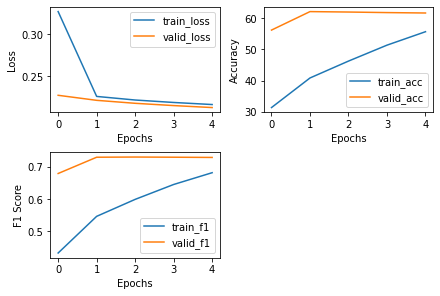

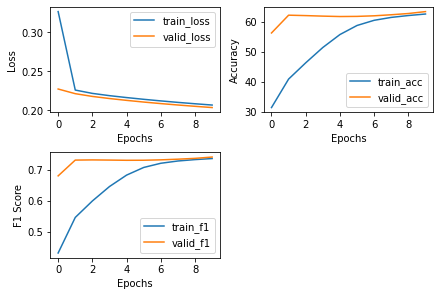

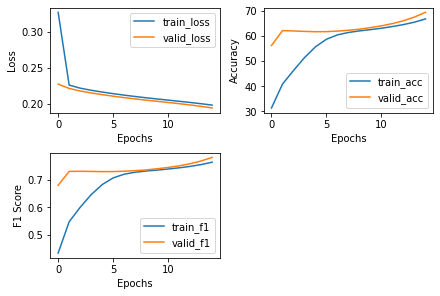

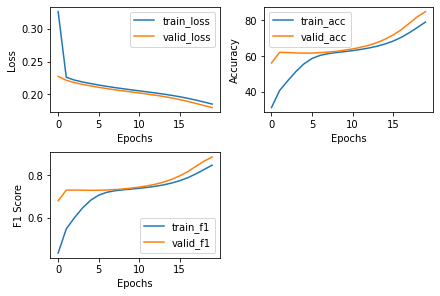

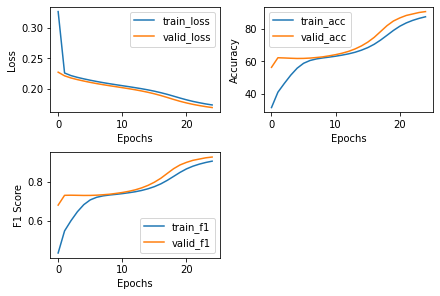

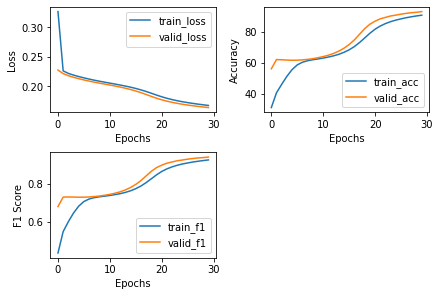

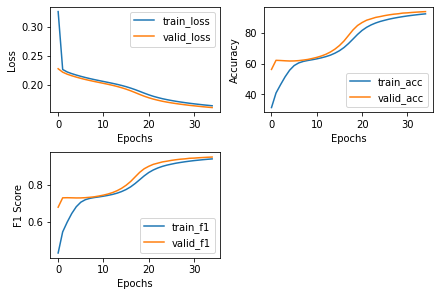

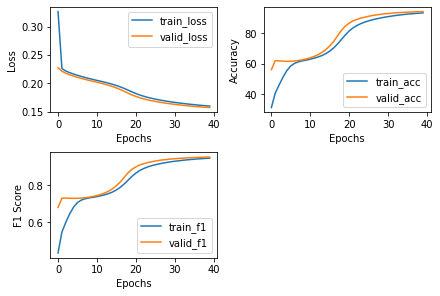

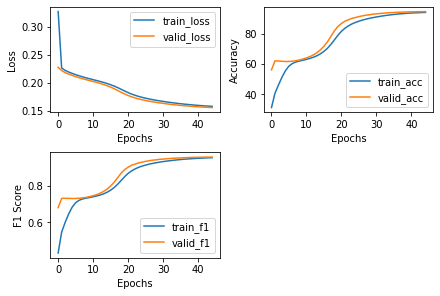

In [32]:
model, history = CallsTrain(model, training_loader, testing_loader, Epochs = 50, name = '/content/drive/MyDrive/punctuation data/Turkish/turk_Bert.pt')

Text(0.5, 1.0, 'Training and Validation F1')

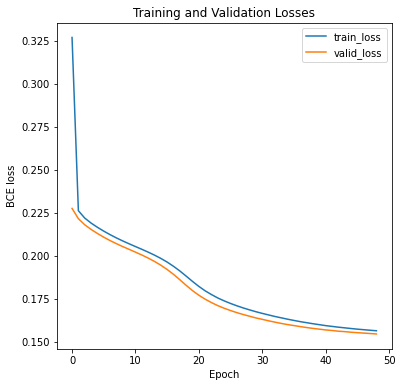

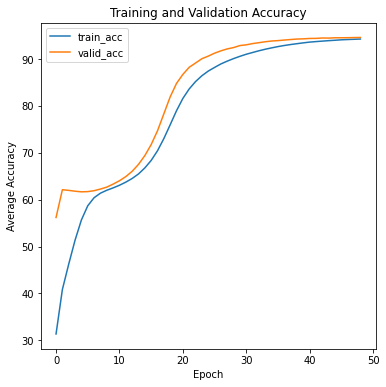

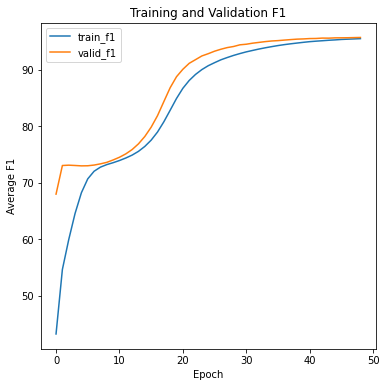

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BCE loss')
plt.title('Training and Validation Losses')

plt.figure(figsize=(6, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(6, 6))
for c in ['train_f1', 'valid_f1']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average F1')
plt.title('Training and Validation F1')

In [ ]:
history.to_csv('./drive/MyDrive/history.csv')

In [ ]:
device = torch.device("cpu")
model.to(device)
test = "aliyeva zemfira musakızı, yılının. "
processed_test = tokenizer(list(test), truncation=True, is_split_into_words=True)
x = torch.tensor(processed_test['input_ids'], dtype=torch.long)
y = torch.tensor(processed_test['attention_mask'], dtype=torch.long)
x = torch.unsqueeze(x, dim=0)
y = torch.unsqueeze(y, dim=0)

In [ ]:
# def validation(epoch, data_loader):
#     # model2.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     softm = torch.nn.Softmax(dim=1)
#     with torch.no_grad():
#         for _, data in enumerate(data_loader, 0):
#             # start_time = time.time()
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.long)
#             outputs = model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.argmax(softm(outputs.logits),dim=1).cpu().detach().numpy().tolist())
#             # print("--- %s seconds ---" % (time.time() - start_time))
#     return outputs, fin_outputs, fin_targets

In [ ]:
softm = torch.nn.Softmax(dim=1)
ids = x.to(device, dtype = torch.long)
mask = y.to(device, dtype = torch.long)
outputs = model(ids, mask)
print(outputs.logits.shape)
fin_outputs = (torch.argmax(softm(outputs.logits),dim=2).cpu().detach().numpy())

In [ ]:
xx = tokenizer.tokenize(test)

In [ ]:
fin_outputs.shape

In [ ]:
indexed_tokens = tokenizer.convert_tokens_to_string(xx)
indexed_tokens